Constructing decaying haltere weights

In [7]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import pickle
from estimator import classical_weights, haltere_covariance_matrix

In [11]:
def haltere_covariance_matrix_decay(N, lowcut, highcut, decay_coef, scale=1):
    '''
    Generates the (N x N) covariance matrix for Gaussain Process inspired by the STAs 
    of mechanosensory neurons in insect halteres. Decaying sinusoids
    
    $$k(t, t') = \mathbb{E}[w(t)^T w(t')] =  \sum_{j=0}^{N-1} \lambda_j \cos{\dfrac{i 2 \pi j (t-t')}{N}} * exp((- \|t- N - 1\|^2 + \|t'- N - 1\|^2) / a ** 2) $$
    $$ \lambda_j = \begin{cases} 1 & lowcut \leq highcut \\ 0 & otherwise \end{cases}$$

    Parameters
    ----------

    N: int
        Number of features
    
    lowcut: int
        low end of the frequency band filter

    highcut : int
        high end of the frequency band filter
        
    decay_coef : float
        controls the how fast the random features decay
    
    scale: float
        Normalization factor for Tr norm of cov matrix
    
    Returns
    -------
    C : array-like of shape (N, N) 
        Covariance matrix
    '''
    
    lamda = np.zeros(N)
    lamda[lowcut:highcut] = 1

    grid = np.arange(0, N)
    yy, xx = np.meshgrid(grid, grid)
    diff = xx - yy

    # sinusoidal part
    C_cos = np.zeros((N, N))
    for j in range(lowcut, highcut):
        C_cos += lamda[j] * np.cos(2 * np.pi * j * diff / N)

    # exponential part
    C_exp = np.exp((-(xx - N) ** 2 - (yy - N) ** 2) / decay_coef ** 2)

    # final covariance matrix
    C = C_cos * C_exp 
    C *= (scale * N / np.trace(C))
    C += 1e-5 * np.eye(N)
    return C

def haltere_inspired_weights_decay(M, N, lowcut, highcut, decay_coef, scale=1, random_state=None):
    """
    Generates random weights with tuning similar to mechanosensory 
    neurons in insect halteres.

    Parameters
    ----------

    M : int
        Number of random weights

    N : int
        Number of features

    lowcut: int
        Low end of the frequency band. 

    highcut: int
        High end of the frequency band.
        
    decay_coef : float
        controls the how fast the random features decay
    
    random_state : int, default=None
        Used to set the seed when generating random weights.
    
    Returns
    -------

    W : array-like of shape (M, N)
        Random weights.
    """
    np.random.seed(random_state)
    C = haltere_covariance_matrix_decay(N, lowcut, highcut, decay_coef, scale)
    L = la.cholesky(C)
    W = np.dot(L, np.random.randn(N, M)).T
    return W

## plotting all covariance matrices

In [3]:
N, lowcut, highcut, decay_coef, scale = 1600, 3, 8, 15, 1

In [4]:
lamda = np.zeros(N)
lamda[lowcut:highcut] = 1

grid = np.arange(0, N)
yy, xx = np.meshgrid(grid, grid)
diff = xx - yy

# sinusoidal part
C_cos = np.zeros((N, N))
for j in range(lowcut, highcut):
    C_cos += lamda[j] * np.cos(2 * np.pi * j * diff / N)

# exponential part
C_exp = np.exp(((xx - N) + (yy - N)) / decay_coef ** 2)

# final covariance matrix
C = C_cos * C_exp 
C *= (scale * N / np.trace(C))
C += 1e-5 * np.eye(N)

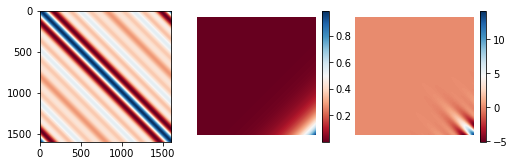

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(131)
plt.imshow(C_cos, cmap='RdBu')

ax = fig.add_subplot(132)
plt.imshow(C_exp, cmap='RdBu')
plt.axis('off')
plt.colorbar(fraction=0.05)
# plt.clim(-4, 4)

ax = fig.add_subplot(133)
plt.imshow(C, cmap='RdBu')
plt.axis('off')
plt.colorbar(fraction=0.05)

(-0.5, 1599.5, 1599.5, -0.5)

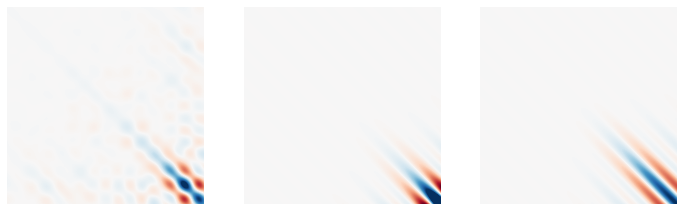

In [9]:
with open('results/haltere_rand_features/Pratt_STA.pickle', 'rb') as handle:
    STA_data = pickle.load(handle) 
C_data = STA_data.T @ STA_data
C_data *= N / np.trace(C_data) 

# C = haltere_covariance_matrix(1600, 2, 8, 50, scale=1)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(131)
plt.imshow(C_data, cmap='RdBu')
cmap_lim = 5
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(132)
plt.imshow(C, cmap='RdBu')
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')
# plt.colorbar()

# ax = fig.add_subplot(133)
# plt.imshow(C_data - C, cmap='RdBu')
# cmap_lim = 5
# plt.clim(-cmap_lim, cmap_lim)
# plt.axis('off')
# plt.colorbar(fraction=0.05)

ax = fig.add_subplot(133)
C_sq = haltere_covariance_matrix_decay(N, lowcut, highcut, 500, scale=1)
plt.imshow(C_sq, cmap='RdBu')
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')
# plt.colorbar()

# plt.savefig('results/haltere_rand_features/covariance_matrices.pdf')

## testing new covariance function

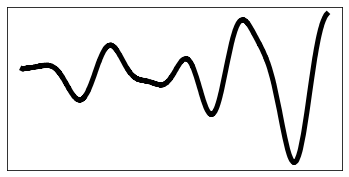

In [13]:
M, N, lowcut, highcut, decay_coef = 20, 1600, 3, 8, 1000
W = haltere_inspired_weights_decay(M, N, lowcut, highcut, decay_coef, random_state=8)
t = np.linspace(0, 1, N)

fig = plt.figure(figsize=(6, 3))
# plt.plot(t, W[0], lw=5, c='k', alpha=0.5)
plt.plot(t, W[1], lw=5, c='k', alpha=1)
plt.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
# plt.savefig('results/haltere_rand_features/decaying_haltere_weights.pdf')

## test on tasks

In [ ]:
import dask
from dask.distributed import Client
client = Client(threads_per_worker=5, n_workers=5)
client

In [ ]:
from data_fns import frequency_detection
from sklearn.model_selection import train_test_split
from estimator import RFClassifier, relu, parallelized_clf
from sklearn.svm import LinearSVC
import pickle
from sklearn.linear_model import SGDClassifier

# load data
n_samples, fs, signal_duration, k, a = 5000, 1500, 0.1, 5, 0.8
X, y = frequency_detection(n_samples, fs, k, signal_duration, a, random_state=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))

# weight params
kwargs = {'lowcut': 2, 'highcut': 8, 'decay_coef': 50}
weights_halteres = {'weight_fun': haltere_inspired_weights, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights}

# params for classification
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
                    learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
b = np.mean(la.norm(X_train)/ np.sqrt(X.shape[0]))

NameError: name 'haltere_inspired_weights' is not defined

In [ ]:
results = {}
l = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': l.copy(), 'std_test_err': l.copy()}
results['halteres'] = {'avg_test_err': l.copy(), 'std_test_err': l.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': sgd}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                   params_classical, 
                                                                                                   X_train, y_train, 
                                                                                                   X_test, y_test, 
                                                                                                   n_iters=5)
    
    # haltere inspired
    params_halteres = {'width': n, **weights_halteres, 'bias': b, 'nonlinearity': relu, 'clf': sgd} 
    _, _, results['halteres']['avg_test_err'][i], results['halteres']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                            params_halteres, 
                                                                                                            X_train, y_train, 
                                                                                                            X_test, y_test, 
                                                                                                            n_iters=5)

    print('Iter: %d/%d' % (i, len(n_features)))
# with open('results/freq_detection/freq_clf_decaying_weights.pickle', 'wb') as handle:
#     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

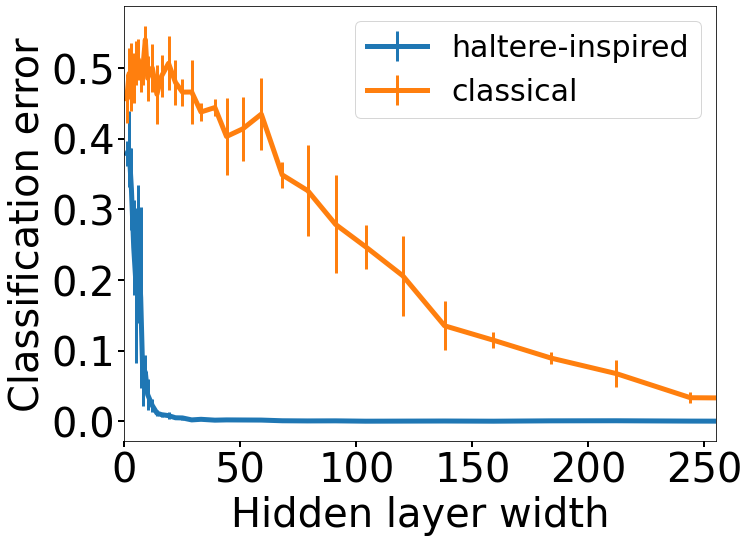

In [6]:
with open('results/freq_detection/freq_clf_decaying_weights.pickle', 'rb') as handle:
    results = pickle.load(handle) 
    
fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['halteres']['avg_test_err'], yerr=results['halteres']['std_test_err'], 
            fmt='-', label='haltere-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
ax.set_xlim([0, 255])
plt.yticks(np.arange(0, 0.6, 0.1))
# plt.ylim([0, 0.55])
# ax.set_yscale('log')
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
plt.xticks(np.arange(0, 255, 50))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)
plt.legend(loc = 'upper right', fontsize=30)
# plt.savefig('results/haltere_rand_features/freq_detection_decaying_weights.pdf')

## Frequency XOR

In [ ]:
from data_fns import frequency_XOR
from sklearn.model_selection import train_test_split
from estimator import RFClassifier, relu
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

# load data
n_samples, fs, signal_duration, k1, k2, a = 5000, 1500, 0.1, 5, 8, 0.99
X, y = frequency_XOR(n_samples, fs, k1, k2, signal_duration, a, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))

# weight params
kwargs = {'lowcut': 3, 'highcut': 13, 'decay_coef': 50}
weights_halteres = {'weight_fun': haltere_inspired_weights, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights}

# params for classification
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
                    learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
b = np.mean(la.norm(X_train)/ np.sqrt(X.shape[0]))

In [ ]:
results = {}
l = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': l.copy(), 'std_test_err': l.copy()}
results['halteres'] = {'avg_test_err': l.copy(), 'std_test_err': l.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': sgd}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                   params_classical, 
                                                                                                   X_train, y_train, 
                                                                                                   X_test, y_test, 
                                                                                                   n_iters=5)
    
    # haltere inspired
    params_halteres = {'width': n, **weights_halteres, 'bias': b, 'nonlinearity': relu, 'clf': sgd} 
    _, _, results['halteres']['avg_test_err'][i], results['halteres']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                            params_halteres, 
                                                                                                            X_train, y_train, 
                                                                                                            X_test, y_test, 
                                                                                                            n_iters=5)

    print('Iter: %d/%d' % (i, len(n_features)))
# with open('results/freq_XOR/freq_XOR_decaying_weights.pickle', 'wb') as handle:
#     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

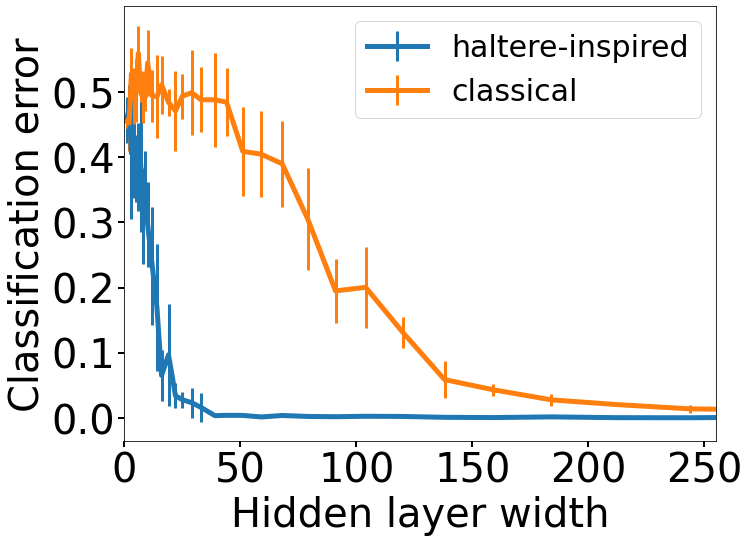

In [7]:
with open('results/freq_XOR/freq_XOR_decaying_weights.pickle', 'rb') as handle:
    results = pickle.load(handle)

fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['halteres']['avg_test_err'], yerr=results['halteres']['std_test_err'], 
            fmt='-', label='haltere-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
ax.set_xlim([0, 255])
plt.yticks(np.arange(0, 0.6, 0.1))
# plt.ylim([0, 0.55])
# ax.set_yscale('log')
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
plt.xticks(np.arange(0, 255, 50))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)
plt.legend(loc = 'upper right', fontsize=30)
# plt.savefig('results/haltere_rand_features/freq_XOR_decaying_weights.pdf')

#### find optimal parameters for covariance functions to fit Pratt et. al's data

In [14]:
def haltere_covariance_matrix_to_minimize(N, lowcut, highcut, decay_coef, scale=1): 
    ''' Changed to a linear programming problem so that it can be minimized easily.
    Find lowcut and highcut real numbers and divide into equally spaced intervals.
    The number of intervals equals to their difference'''
    
    grid = np.arange(0, N)
    yy, xx = np.meshgrid(grid, grid)
    diff = xx - yy

    # sinusoidal part
    t = int(np.round(highcut - lowcut)) # number of intervals
    C_cos = np.zeros((N, N))
    for j in np.linspace(lowcut, highcut, t): # divide into number of intervals
        C_cos += np.cos(2 * np.pi * j * diff / N)

    # exponential part
#     C_exp = np.exp((-(xx - N) ** 2 - (yy - N) ** 2) / decay_coef ** 2)
    C_exp = np.exp(((xx - N) + (yy - N)) / decay_coef ** 2)

    # final covariance matrix
    C = C_cos * C_exp 
    C *= (scale * N / np.trace(C))
    C += 1e-5 * np.eye(N)
    return C

def haltere_covariance_matrix(N, lowcut, highcut, decay_coef, scale=1): 
    grid = np.arange(0, N)
    yy, xx = np.meshgrid(grid, grid)
    diff = xx - yy

    # sinusoidal part
    C_cos = np.zeros((N, N))
    for j in range(lowcut, highcut):
        C_cos += np.cos(2 * np.pi * j * diff / N)

    # exponential part
#     C_exp = np.exp((-(xx - N) ** 2 - (yy - N) ** 2) / decay_coef ** 2)
    C_exp = np.exp(((xx - N) + (yy - N)) / decay_coef ** 2)

    # final covariance matrix
    C = C_cos * C_exp 
    C *= (scale * N / np.trace(C))
    C += 1e-5 * np.eye(N)
    return C


def haltere_inspired_weights(M, N, lowcut, highcut, decay_coef, scale=1, random_state=None):
    np.random.seed(random_state)
    C = haltere_covariance_matrix(N, lowcut, highcut, decay_coef, scale)
    L = la.cholesky(C)
    W = np.dot(L, np.random.randn(N, M)).T
    return W

In [15]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

## load data covariance matrix
with open('results/haltere_rand_features/Pratt_STA.pickle', 'rb') as handle:
    STA_data = pickle.load(handle) 

nCells, dim = STA_data.shape
nCells = len(STA_data)
C_data = STA_data.T @ STA_data
C_data *= dim / np.trace(C_data) 

In [16]:
from scipy.optimize import minimize
def diff(x):
    cov_data = C_data.copy()
    cov_model = haltere_covariance_matrix_to_minimize(dim, lowcut=x[0], highcut=x[1], decay_coef=x[2], scale=1)
    return la.norm(cov_model - cov_data)

# find a way to constrain value of lowcut, highcut to be integer and lowcut < highcut
x0 = [3, 8, 20] #sq: (1, 20, 1000), non sq: [3, 8, 20]
cons = ({'type': 'ineq', 'fun': lambda x:  x[1] - x[0]})

min_diff = minimize(diff, x0, method='SLSQP', constraints=cons, tol=1e-4)
lowcut_min, highcut_min, decay_coef_min = min_diff.x
print("Optimal params: lowcut=%0.3f, highcut=%0.3f, decay_coef=%0.3f" %(lowcut_min, highcut_min, decay_coef_min))

<ipython-input-14-a164e1dff66f>:22: RuntimeWarning: divide by zero encountered in double_scalars
  C *= (scale * N / np.trace(C))
<ipython-input-14-a164e1dff66f>:22: RuntimeWarning: invalid value encountered in multiply
  C *= (scale * N / np.trace(C))


ValueError: cannot convert float NaN to integer

In [188]:
lowcut, highcut, decay_coef = int(np.round(lowcut_min)), int(np.round(highcut_min)), decay_coef_min.copy()

# model
C_model = haltere_covariance_matrix(dim, lowcut, highcut, decay_coef, scale=1)

# finite sample
W = haltere_inspired_weights(nCells, dim, lowcut, highcut, decay_coef=decay_coef, random_state=5)
C_model_finite_sample = W.T @ W
C_model_finite_sample *= dim / np.trace(C_model_finite_sample).reshape(-1, 1)

# spectra analyses
eigval_data, eigvec_data = la.eigh(C_data)
eigval_data /= np.sum(eigval_data)
eigval_model, eigvec_model = la.eigh(C_model)
eigval_model /= np.sum(eigval_model)
eigval_model_finite_sample, eigvec_model_finite_sample = la.eigh(C_model_finite_sample) 
eigval_model_finite_sample /= np.sum(eigval_model_finite_sample)

(-0.5, 1599.5, 1599.5, -0.5)

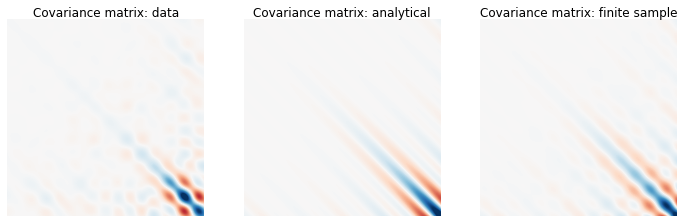

In [189]:
# plot covariance matrices
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(131)
plt.title('Covariance matrix: data', y=0.98)
plt.imshow(C_data, cmap='RdBu')
cmap_lim = 5
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')
# plt.colorbar()

ax = fig.add_subplot(132)
plt.title('Covariance matrix: analytical', y=0.98)
plt.imshow(C_model, cmap='RdBu')
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')
# plt.colorbar(fraction=0.04)

ax = fig.add_subplot(133)
plt.title('Covariance matrix: finite sample', y=0.98)
plt.imshow(C_model_finite_sample, cmap='RdBu')
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')
# plt.colorbar(fraction=0.02)
# plt.savefig('results/haltere_rand_features/covariance_matrices_fitted.pdf')

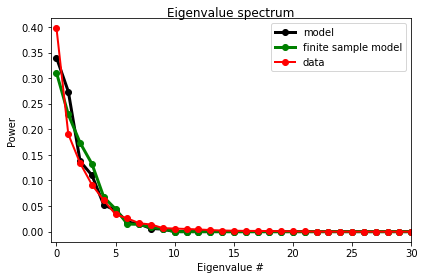

In [227]:
# plot eigenvectors
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title('Eigenvalue spectrum', y=0.98)
plt.plot(np.flip(eigval_model), 'k-o', lw=3,label='model')
plt.plot(np.flip(eigval_model_finite_sample), '-go', lw=3,  label='finite sample model')
plt.plot(np.flip(eigval_data), 'r-o', lw=2, label='data')
plt.xlim(-0.5, 30)
plt.xlabel('Eigenvalue #')
plt.ylabel('Power')
# plt.ylim(1e-4, 1e3)
plt.legend()
plt.tight_layout()
# plt.savefig('results/haltere_rand_features/eig_vals_fitted_covariance_mat.pdf')

In [225]:
np.sum(eigval_data[-6:]), np.sum(eigval_model[- 6:]), np.sum(eigval_model_finite_sample[-6:])

(0.9084006556435009, 0.9553244447767477, 0.9571531425895559)

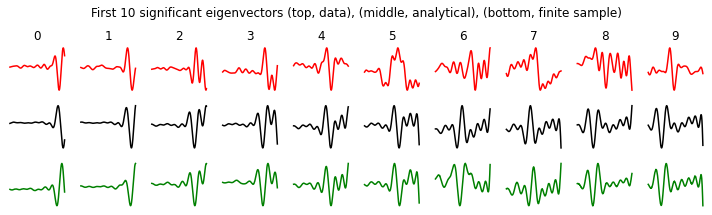

In [200]:
## plot eigenvectors
fig = plt.figure(figsize=(10, 3))
plt.suptitle('First 10 significant eigenvectors (top, data), (middle, analytical), (bottom, finite sample)')
for i in range(10):
    ax = fig.add_subplot(3, 10, i+1)
    ax.set_title(i)
    plt.plot(eigvec_data[:, -i - 1], c='r')
    plt.axis('off')
    
    ax = fig.add_subplot(3, 10, 10 + i +1)
    plt.plot(eigvec_model[:, -i - 1], c='k')
    plt.axis('off')
    
    ax = fig.add_subplot(3, 10, 20 + i +1)
    plt.plot(eigvec_model_finite_sample[:, -i - 1], c='g')
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.8)
# plt.savefig('results/haltere_rand_features/eig_vecs_fitted_covariance_mat.pdf')

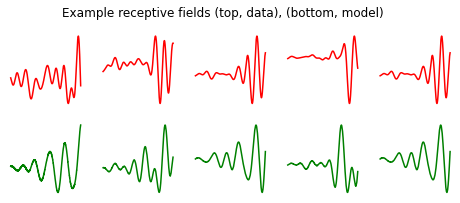

In [182]:
# plot a few receptive fields
fig = plt.figure(figsize=(8, 3))
plt.suptitle('Example receptive fields (top, data), (bottom, model)', y=1)
for i in range(5):
    ax = fig.add_subplot(2, 5, i+1)
    idx = np.random.randint(nCells)
    plt.plot(STA_data[idx], 'r')
    plt.axis('off')
    

    ax = fig.add_subplot(2, 5, 5 + i+1)
    plt.plot(W[idx], 'g')
    plt.axis('off')
# plt.savefig('results/haltere_rand_features/receptive_fields_fitted.pdf')

### Generate covariance matrix using Laguerre polynomials

In [ ]:
from scipy.special import eval_laguerre, eval_hermitenorm
import numpy as np
import matplotlib.pyplot as plt

# plot laguerre polynomials
t = np.arange(0, 1600)
a = 30

fig = plt.figure()
for i in range(0, 5):
    plt.plot(np.exp(-t / (2 * a)) * eval_laguerre(i, t / a ))

Generate haltere type weights as random linear combination of laguerre polynomials
$$w(t) = \sum_{k=\text{lowcut}}^{\text{highcut}} \eta_k e^{\dfrac{-t}{2 * \text{decay rate}}} \cdot L_k \bigg(\dfrac{t}{\text{decay rate}}\bigg); \eta_k = \mathcal{N}(0, 1)$$

In [ ]:
def laguerre_weights(M, N, lowcut, highcut, decay_coef):
    ''' Generate weights that are random linear combinations of normalized polynomials
    w(t) = \sum_{k=lowcut}^highcut \eta_i e^(-t / (2 * decay_rate)) * L_k(t / decay_coef)
    '''
    t = np.arange(N)
    D = np.zeros((highcut - lowcut, N))

    for i, j in enumerate(range(lowcut, highcut)):
        D[i] = np.exp(-t / (2 * decay_coef)) * eval_laguerre(j, t / decay_coef)

    rand = np.random.normal(size=(M, highcut-lowcut))
    return np.flip(rand @ D)


M, N = 100, 1600
lowcut, highcut, decay_coef = 2, 8, 40
W_lag = laguerre_weights(M, N, lowcut, highcut, decay_coef)

fig = plt.figure(figsize=(8, 3))
for i in range(5):
    ax = fig.add_subplot(2, 5, i+1)
    idx = np.random.randint(nCells)
    plt.plot(STA_data[idx], 'r')
    plt.axis('off')
    

    ax = fig.add_subplot(2, 5, 5 + i+1)
    plt.plot(W_lag[idx], 'g')
    plt.axis('off')

In [ ]:
# generate covariance matrix and eigenvals
# W_lag = laguerre_weights(95, 1600, 3, 8, 50)
C_finite_sample_lag = W_lag.T @ W_lag
C_finite_sample_lag *= dim / np.trace(C_finite_sample_lag).reshape(-1, 1)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(131)
plt.title('Covariance matrix: data', y=0.98)
plt.imshow(C_data, cmap='RdBu')
cmap_lim = 3
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')
# plt.colorbar()


ax = fig.add_subplot(133)
plt.title('Covariance matrix Laguerre: finite sample', y=0.98)
plt.imshow(C_finite_sample_lag, cmap='RdBu')
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')
plt.colorbar(fraction=0.02)

Generate covariace matrix from Laguerre polynomials

$$
 C(t, t') = \sum_{i= \text{lowcut}}^\text{highcut} e^{-t / (2 * \text{decay coef})} e^{-t' / (2 * \text{decay coef})} L_k(t / \text{decay coef}) L_k(t' / \text{decay coef})
$$

In [ ]:
def laguerre_covariance_matrix(N, lowcut, highcut, decay_coef, scale=1): 
    ''' 
    Generate covariance matrix with laguerre polynomials.
    C(t, t') = \sum_{i=lowcut}^highcut e^{-t / (2 * decay_rate)} e^{-t' / (2 * decay_rate)} L_k(t / ( decay_rate)) L_k(t' / (2 * decay_rate))
    
    '''
    grid = np.arange(0, N)
    yy, xx = np.meshgrid(grid, grid)
    diff = xx - yy

    # laguerre part
    C_lag = np.zeros((N, N))
    for j in range(lowcut, highcut):
        C_lag += eval_laguerre(j, xx / decay_coef) * eval_laguerre(j, yy / decay_coef)

    # exponential part
    C_exp = np.exp((-xx - yy) / (2 * decay_coef))

    # final covariance matrix
    C = C_lag * C_exp
    C *= (scale * N / np.trace(C))
    C += 1e-5 * np.eye(N)
    return C

In [ ]:
C_lag = laguerre_covariance_matrix(N, 2, 8, 40, scale=1)
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(131)
plt.title('Covariance matrix: data', y=0.98)
plt.imshow(C_data, cmap='RdBu')
cmap_lim = 3
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')
# plt.colorbar()


ax = fig.add_subplot(133)
plt.title('Covariance matrix Laguerre', y=0.98)
plt.imshow(np.flip(C_lag), cmap='RdBu')
plt.clim(-cmap_lim, cmap_lim)
plt.axis('off')
plt.colorbar(fraction=0.02)